In [35]:
import torch 
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype

from tqdm.auto import tqdm
import seaborn as sns

from torchmetrics import Accuracy
from torchmetrics import ConfusionMatrix

import matplotlib.pyplot as plt

In [36]:
data = pd.read_csv(r"data\FashionMNIST\raw\diabetes_prediction_dataset.csv")
data = data.sample(frac=1)
data.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 55720 to 35113
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 7.6+ MB


In [37]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,100000.0,41.885856,22.516840,0.08,24.00,43.00,60.00,80.00
hypertension,100000.0,0.074850,0.263150,0.00,0.00,0.00,0.00,1.00
heart_disease,100000.0,0.039420,0.194593,0.00,0.00,0.00,0.00,1.00
bmi,100000.0,27.320767,6.636783,10.01,23.63,27.32,29.58,95.69
HbA1c_level,100000.0,5.527507,1.070672,3.50,4.80,5.80,6.20,9.00
blood_glucose_level,100000.0,138.058060,40.708136,80.00,100.00,140.00,159.00,300.00
diabetes,100000.0,0.085000,0.278883,0.00,0.00,0.00,0.00,1.00


array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'hypertension'}>,
        <Axes: title={'center': 'heart_disease'}>],
       [<Axes: title={'center': 'bmi'}>,
        <Axes: title={'center': 'HbA1c_level'}>,
        <Axes: title={'center': 'blood_glucose_level'}>],
       [<Axes: title={'center': 'diabetes'}>, <Axes: >, <Axes: >]],
      dtype=object)

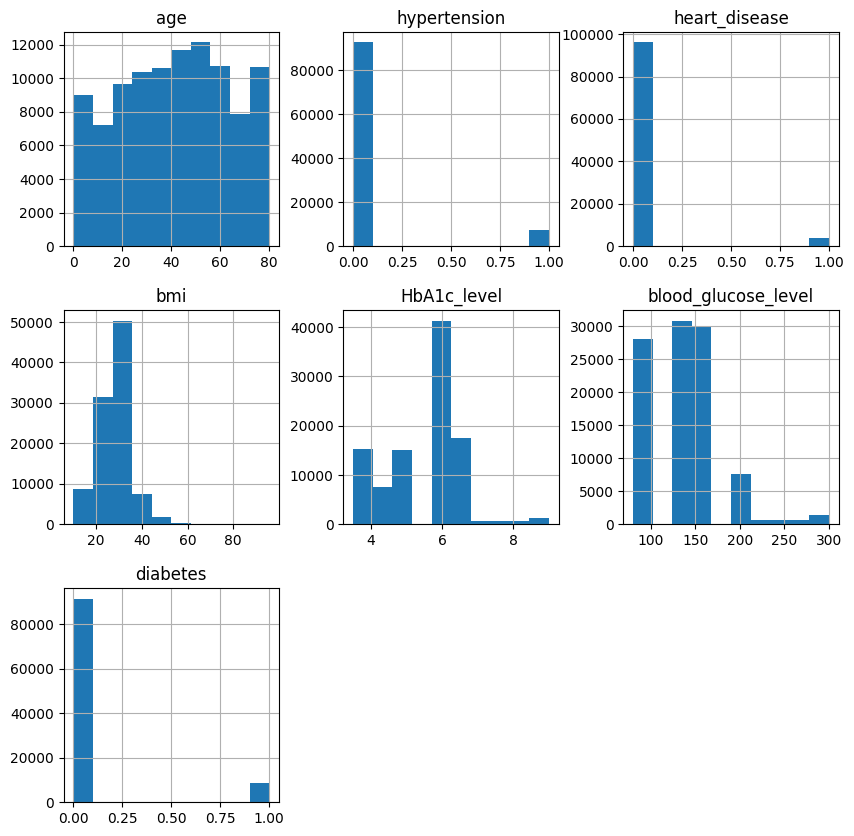

In [38]:
data.hist(figsize = (10,10))

In [39]:
#p=sns.pairplot(data, hue='diabetes')

In [40]:
gender_dict = {"Male": 0, "Female": 1, "Other": 2}
smoking_dict = {"No Info": 0, "never": 1, "current": 2, "former": 3, "ever": 4, "not current": 5}
data=data.replace({"gender": gender_dict, "smoking_history": smoking_dict})

for columns in data:
    print(is_numeric_dtype(data[columns]))

print(len(data))

True
True
True
True
True
True
True
True
True
100000


In [41]:

diabetes_data = data[data["diabetes"] == 1]

new_data = data[data.diabetes == 0]
new_data = new_data[:len(diabetes_data)]

#data = data.sample(frac=1)
new_data = pd.concat([diabetes_data, new_data]).sample(frac=1)
new_data


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
98496,0,32.0,0,0,2,32.59,5.0,159,0
26283,0,60.0,0,1,4,26.41,6.8,126,1
2118,1,29.0,0,0,1,33.32,3.5,90,0
53373,1,62.0,0,0,1,39.47,6.2,155,0
74899,1,80.0,0,1,3,29.51,6.2,140,1
...,...,...,...,...,...,...,...,...,...
45464,0,62.0,0,0,0,27.32,6.6,130,1
98399,0,73.0,0,0,0,27.32,8.8,300,1
85616,0,60.0,0,0,3,31.75,6.1,280,1
51750,0,74.0,0,0,0,27.32,5.8,159,1


In [42]:
new_data.drop(columns=["diabetes"]).values

array([[  0.  ,  32.  ,   0.  , ...,  32.59,   5.  , 159.  ],
       [  0.  ,  60.  ,   0.  , ...,  26.41,   6.8 , 126.  ],
       [  1.  ,  29.  ,   0.  , ...,  33.32,   3.5 ,  90.  ],
       ...,
       [  0.  ,  60.  ,   0.  , ...,  31.75,   6.1 , 280.  ],
       [  0.  ,  74.  ,   0.  , ...,  27.32,   5.8 , 159.  ],
       [  1.  ,  21.  ,   0.  , ...,  22.37,   5.  , 145.  ]])

In [43]:
class DiabetesDataset(Dataset):
    def __init__(self, data, transform=None, target_transform=None):
        self.data = torch.tensor(data.drop(columns=["diabetes"]).values, dtype=torch.float32)
        self.label = torch.tensor(data["diabetes"].values, dtype=torch.float32)
        self.transform = transform
        self.target_transform = target_transform
        self.classes_num = self.label.unique()

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.data[idx], self.label[idx]

BATCH_SIZE = 16


train_data, test_data = np.split(new_data, [int(0.8*len(new_data))])

train_dataset = DiabetesDataset(data=train_data)
test_dataset = DiabetesDataset(data=test_data)

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

print((train_dataset.label == 0).sum())


tensor(6804)


In [44]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               acc_fn,
               device="cuda"):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += acc_fn(y_pred, y)

        loss /= len(data_loader)
        acc /= len(data_loader)

    return {
        "model_name": model.__class__.__name__,
        "model_loss": loss.item(),
        "model_acc": acc.item()
    }

In [45]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               acc_fn: torch.nn.Module,
               device: torch.device = "cuda"):

    train_loss, train_acc = 0, 0
    model.train()

    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        y_logits = model(X).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits))

        loss = loss_fn(y_logits, y)
        train_loss += loss
        train_acc += acc_fn(y_pred, y)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    print(f"Train loss: {train_loss:.5f} | Train acc: {100 * train_acc:.5f}%")

In [46]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              acc_fn,
              device: torch.device = "cuda"):


    test_loss, test_acc = 0, 0

    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            test_logits = model(X).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits))

            test_loss += loss_fn(test_logits, y)

            test_acc += acc_fn(test_pred, y)

        test_loss /= len(test_dataloader)

        test_acc /= len(test_dataloader)

    print(f"Test loss: {test_loss:.4f}, Test acc: {100 * test_acc:.4f}")

In [47]:
device = "cuda" if torch.cuda.is_available() else "cpu"


class DiabetesModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_block = nn.Sequential(
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape)
        )


    def forward(self, x):
        return self.layer_block(x)

In [48]:

model_0 = DiabetesModelV0(input_shape=8, hidden_units=16, output_shape=1).to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.005)
acc_fn = Accuracy(task="binary").to(device)

In [49]:
epochs = 20

for epoch in tqdm(range(epochs)):
    train_step(model=model_0,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               acc_fn=acc_fn,
               device=device)
    test_step(model=model_0,
               data_loader=test_dataloader,
               loss_fn=loss_fn,
               acc_fn=acc_fn,
               device=device)


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 0.59245 | Train acc: 67.82353%


  5%|▌         | 1/20 [00:04<01:29,  4.71s/it]

Test loss: 0.5524, Test acc: 70.2171
Train loss: 0.55441 | Train acc: 69.99265%


 10%|█         | 2/20 [00:07<01:06,  3.68s/it]

Test loss: 0.5737, Test acc: 70.9800
Train loss: 0.53904 | Train acc: 70.75000%


 15%|█▌        | 3/20 [00:10<00:57,  3.39s/it]

Test loss: 0.5163, Test acc: 71.0094
Train loss: 0.52433 | Train acc: 72.09558%


 20%|██        | 4/20 [00:13<00:52,  3.28s/it]

Test loss: 0.5027, Test acc: 73.3862
Train loss: 0.51587 | Train acc: 73.30147%


 25%|██▌       | 5/20 [00:16<00:47,  3.19s/it]

Test loss: 0.4967, Test acc: 73.9437
Train loss: 0.50736 | Train acc: 73.78676%


 30%|███       | 6/20 [00:20<00:44,  3.18s/it]

Test loss: 0.4913, Test acc: 74.7946
Train loss: 0.49716 | Train acc: 74.58823%


 35%|███▌      | 7/20 [00:23<00:41,  3.16s/it]

Test loss: 0.5133, Test acc: 70.4519
Train loss: 0.49139 | Train acc: 75.26470%


 40%|████      | 8/20 [00:26<00:37,  3.14s/it]

Test loss: 0.4847, Test acc: 75.2934
Train loss: 0.48626 | Train acc: 76.09559%


 45%|████▌     | 9/20 [00:29<00:34,  3.12s/it]

Test loss: 0.4699, Test acc: 77.6115
Train loss: 0.47961 | Train acc: 76.58823%


 50%|█████     | 10/20 [00:32<00:31,  3.10s/it]

Test loss: 0.4626, Test acc: 79.4014
Train loss: 0.47451 | Train acc: 77.36765%


 55%|█████▌    | 11/20 [00:35<00:27,  3.09s/it]

Test loss: 0.4774, Test acc: 78.9906
Train loss: 0.46947 | Train acc: 77.63235%


 60%|██████    | 12/20 [00:38<00:24,  3.10s/it]

Test loss: 0.4568, Test acc: 76.4378
Train loss: 0.46412 | Train acc: 77.72794%


 65%|██████▌   | 13/20 [00:41<00:21,  3.09s/it]

Test loss: 0.4409, Test acc: 78.4331
Train loss: 0.45900 | Train acc: 78.36765%


 70%|███████   | 14/20 [00:44<00:18,  3.11s/it]

Test loss: 0.4405, Test acc: 81.1913
Train loss: 0.45374 | Train acc: 78.82352%


 75%|███████▌  | 15/20 [00:47<00:15,  3.11s/it]

Test loss: 0.4257, Test acc: 82.2770
Train loss: 0.45153 | Train acc: 78.50735%


 80%|████████  | 16/20 [00:50<00:12,  3.09s/it]

Test loss: 0.4442, Test acc: 76.6138
Train loss: 0.44546 | Train acc: 79.49265%


 85%|████████▌ | 17/20 [00:54<00:09,  3.10s/it]

Test loss: 0.4541, Test acc: 77.1420
Train loss: 0.44228 | Train acc: 79.36765%


 90%|█████████ | 18/20 [00:57<00:06,  3.10s/it]

Test loss: 0.4096, Test acc: 83.2160
Train loss: 0.43908 | Train acc: 79.58823%


 95%|█████████▌| 19/20 [01:00<00:03,  3.09s/it]

Test loss: 0.4475, Test acc: 76.4378
Train loss: 0.43512 | Train acc: 79.87500%


100%|██████████| 20/20 [01:03<00:00,  3.17s/it]

Test loss: 0.4081, Test acc: 83.4507


In [50]:
y_preds = []
model_0.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions..."):
        X, y = X.to(device), y.to(device)
        y_logit = model_0(X)
        y_logits = torch.round(torch.softmax(y_logit.squeeze(), dim=0)).cpu()
        y_preds.append(y_logits)

y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[6], len(y_pred_tensor)

Making predictions...: 100%|██████████| 213/213 [00:00<00:00, 1263.73it/s]


(tensor(1.), 3400)

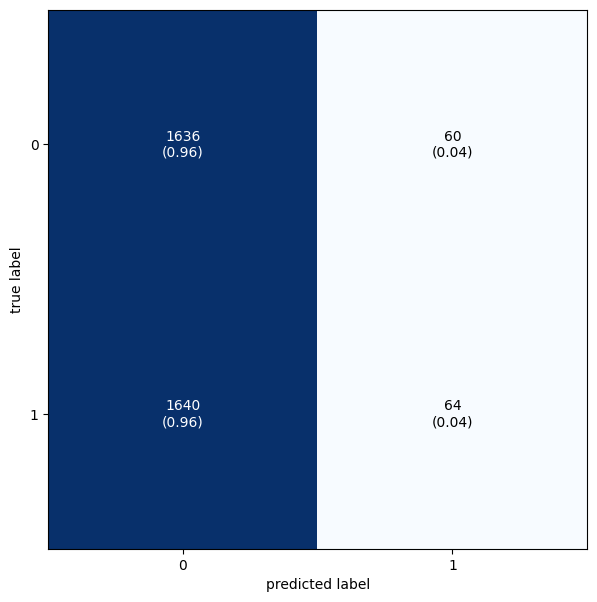

In [51]:
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(task="binary")
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_dataset.label)

fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                                show_absolute=True,
                                show_normed=True,
                                figsize=(10, 7))